Lecture 9: Temporal Features
==============================

Key Learning Objectives:
1. Understand the importance of temporal features
2. Learn different techniques for date-based feature engineering
3. Create cyclical features for periodic patterns
4. Extract time-based trends and patterns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
# Load the dataset
df = pd.read_csv('loan_applications.csv')

In [ ]:
# Convert application_date to datetime
df['application_date'] = pd.to_datetime(df['application_date'])
df_temporal = df.copy()

In [ ]:
# 1. Extract Basic Time Components
df_temporal['year'] = df_temporal['application_date'].dt.year
df_temporal['month'] = df_temporal['application_date'].dt.month
df_temporal['day'] = df_temporal['application_date'].dt.day
df_temporal['day_of_week'] = df_temporal['application_date'].dt.dayofweek
df_temporal['quarter'] = df_temporal['application_date'].dt.quarter
df_temporal['is_weekend'] = df_temporal['day_of_week'].isin([5, 6]).astype(int)

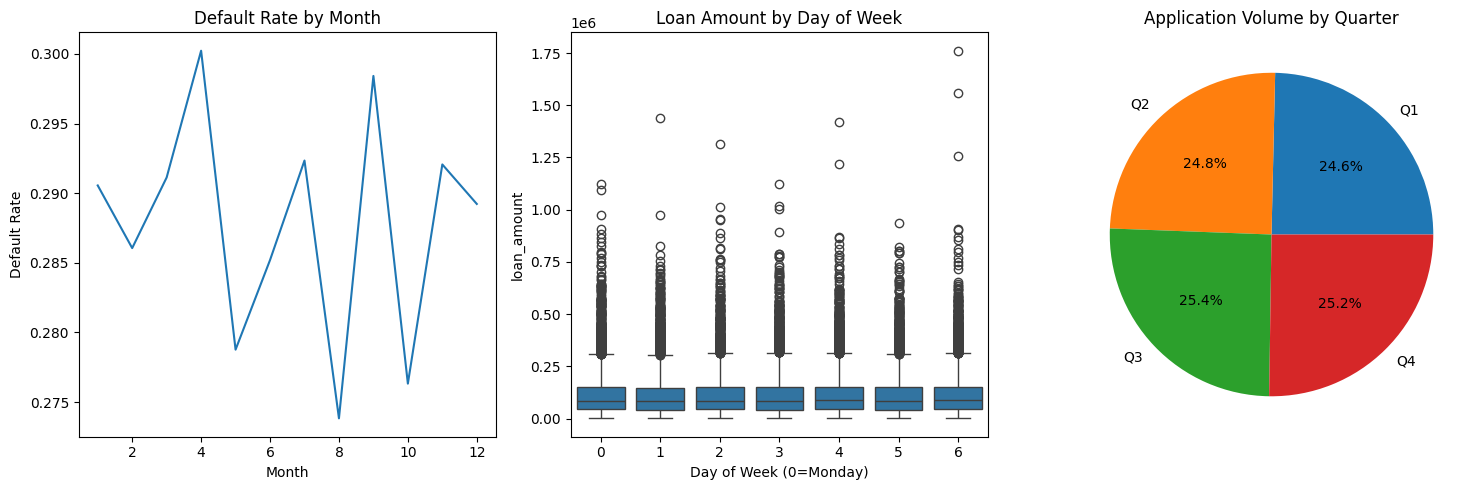

In [ ]:
# Visualize temporal patterns
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
monthly_defaults = df_temporal.groupby('month')['default'].mean()
sns.lineplot(x=monthly_defaults.index, y=monthly_defaults.values)
plt.title('Default Rate by Month')
plt.xlabel('Month')
plt.ylabel('Default Rate')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_temporal, x='day_of_week', y='loan_amount')
plt.title('Loan Amount by Day of Week')
plt.xlabel('Day of Week (0=Monday)')

plt.subplot(1, 3, 3)
quarterly_volumes = df_temporal.groupby('quarter').size()
plt.pie(quarterly_volumes, labels=[f'Q{i}' for i in range(1, 5)],
        autopct='%1.1f%%')
plt.title('Application Volume by Quarter')

plt.tight_layout()
plt.show()

## Time-Based Features
----------------------
Create features based on temporal relationships and patterns.

In [ ]:
# 1. Monthly Patterns
monthly_stats = df_temporal.groupby('month').agg({
    'loan_amount': ['mean', 'count'],
    'default': 'mean'
}).round(3)

In [ ]:
# 2. Seasonal Indices
def calculate_seasonal_index(df, feature, period_col):
    # Calculate overall mean
    overall_mean = df[feature].mean()

    # Calculate period means
    period_means = df.groupby(period_col)[feature].mean()

    # Calculate seasonal indices
    seasonal_indices = period_means / overall_mean

    return seasonal_indices

In [ ]:
seasonal_indices = {
    'loan_amount': calculate_seasonal_index(df_temporal, 'loan_amount', 'month'),
    'default_rate': calculate_seasonal_index(df_temporal, 'default', 'month')
}

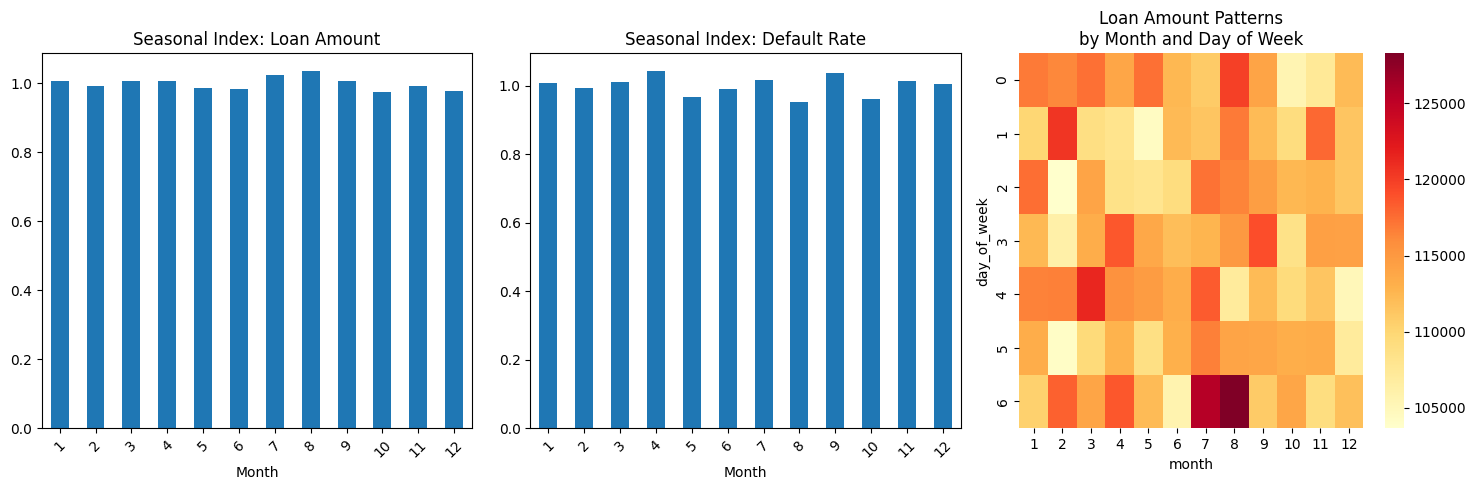

In [ ]:
# Visualize seasonal patterns
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
seasonal_indices['loan_amount'].plot(kind='bar')
plt.title('Seasonal Index: Loan Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
seasonal_indices['default_rate'].plot(kind='bar')
plt.title('Seasonal Index: Default Rate')
plt.xlabel('Month')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(df_temporal.pivot_table(
    index='day_of_week',
    columns='month',
    values='loan_amount',
    aggfunc='mean'
), cmap='YlOrRd')
plt.title('Loan Amount Patterns\nby Month and Day of Week')

plt.tight_layout()
plt.show()


# Lecture 10: Aggregating Features (12m)
=================================


Key Learning Objectives:
1. Understand different types of aggregations
2. Create group-based statistical features
3. Implement temporal aggregations
4. Evaluate aggregation effectiveness

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Load the dataset with interactions
df = pd.read_csv('loan_applications.csv')

In [ ]:
# Define groups and metrics for aggregation
categorical_groups = ['education', 'occupation', 'city']
numerical_features = ['income', 'loan_amount', 'monthly_payment', 'credit_score']
df_agg = df.copy()

# 1. Basic Statistical Aggregations
for group in categorical_groups:
    for feature in numerical_features:
        # Mean and standard deviation
        group_mean = df.groupby(group)[feature].transform('mean')
        group_std = df.groupby(group)[feature].transform('std')

        # Z-score within group
        df_agg[f'{feature}_{group}_zscore'] = (df[feature] - group_mean) / group_std

        # Percentile within group
        df_agg[f'{feature}_{group}_percentile'] = df.groupby(group)[feature].transform(
            lambda x: pd.qcut(x, q=100, labels=False, duplicates='drop')
        )

In [ ]:
# 2. Ratio to Group Statistics
for group in categorical_groups:
    for feature in numerical_features:
        # Ratio to group mean
        group_mean = df.groupby(group)[feature].transform('mean')
        df_agg[f'{feature}_{group}_ratio'] = df[feature] / group_mean

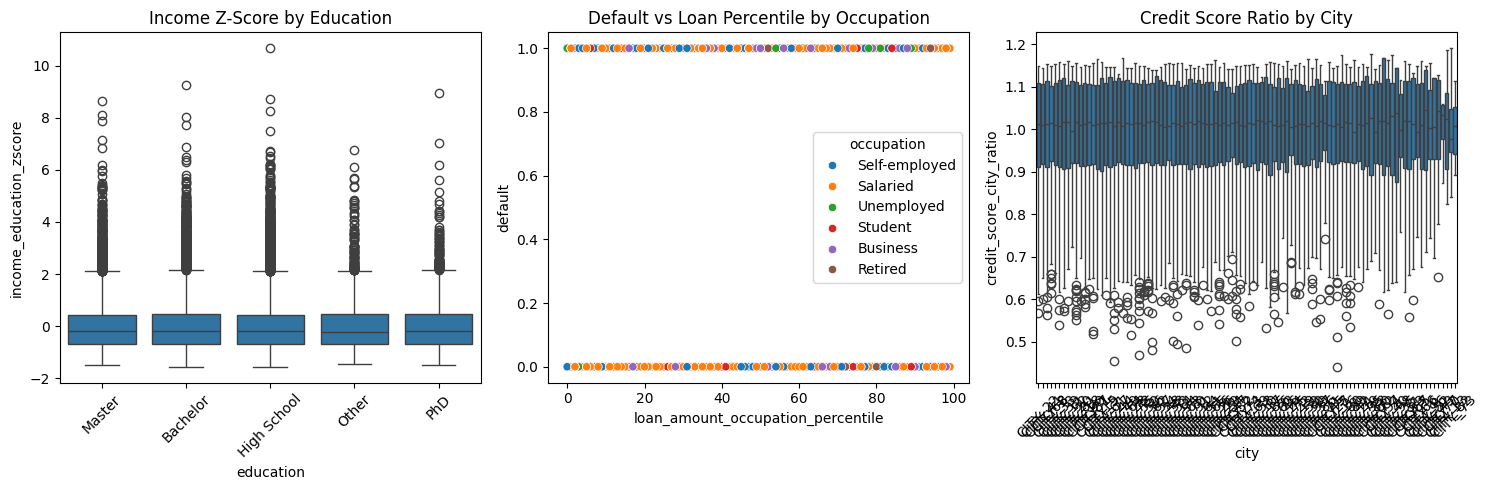

In [ ]:
# Visualize group-based aggregations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df_agg, x='education',
            y='income_education_zscore')
plt.title('Income Z-Score by Education')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_agg,
                x='loan_amount_occupation_percentile',
                y='default', hue='occupation')
plt.title('Default vs Loan Percentile by Occupation')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_agg, x='city',
            y='credit_score_city_ratio')
plt.title('Credit Score Ratio by City')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Lecture 11: Handling Imbalanced Datasets
=======================================


We'll learn four main approaches:
1. Understanding and Measuring Imbalance
2. Oversampling Techniques (SMOTE)
3. Undersampling Strategies
4. Combining Methods

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [ ]:
# Load our dataset
df = pd.read_csv('loan_applications.csv')

In [ ]:
# Select relevant numerical features
numerical_features = [
    'age', 'employment_length', 'income', 'loan_amount',
    'loan_term', 'interest_rate', 'monthly_payment',
    'credit_score'
]

# Handle missing values
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# Prepare features and target
X = df[numerical_features]
y = df['default']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Calculate class distribution
class_counts = df['default'].value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]

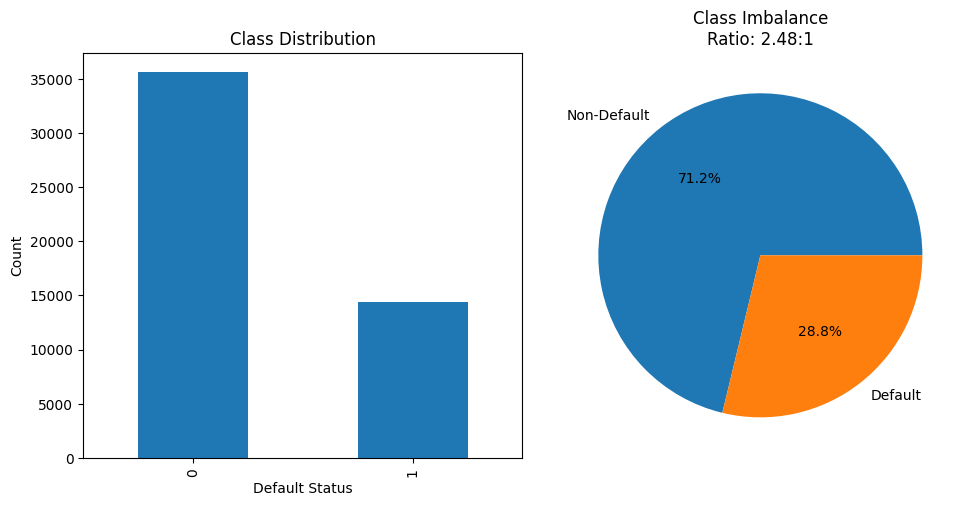

In [ ]:
# Visualize class imbalance
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Default Status')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%')
plt.title(f'Class Imbalance\nRatio: {imbalance_ratio:.2f}:1')

plt.tight_layout()
plt.show()

## Oversampling with SMOTE
-------------------------
SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic
examples of the minority class.

In [ ]:
# Print class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))

Class distribution before SMOTE:
default
0    0.711225
1    0.288775
Name: proportion, dtype: float64


In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Print class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


Class distribution after SMOTE:
default
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# Visualize feature distributions before and after SMOTE
def plot_feature_distributions(X_orig, X_smote, y_orig, y_smote, feature_idx):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for label in [0, 1]:
        sns.kdeplot(X_orig[y_orig == label, feature_idx],
                   label=f"Class {label}")
    plt.title("Original Distribution")
    plt.xlabel(numerical_features[feature_idx])

    plt.subplot(1, 2, 2)
    for label in [0, 1]:
        sns.kdeplot(X_smote[y_smote == label, feature_idx],
                   label=f"Class {label}")
    plt.title("After SMOTE")
    plt.xlabel(numerical_features[feature_idx])

    plt.tight_layout()
    plt.show()

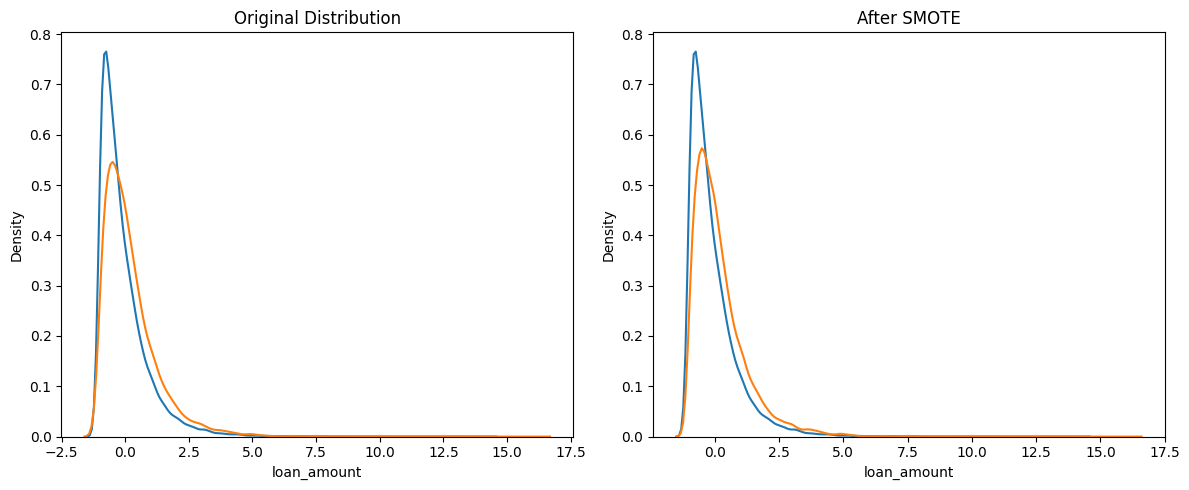

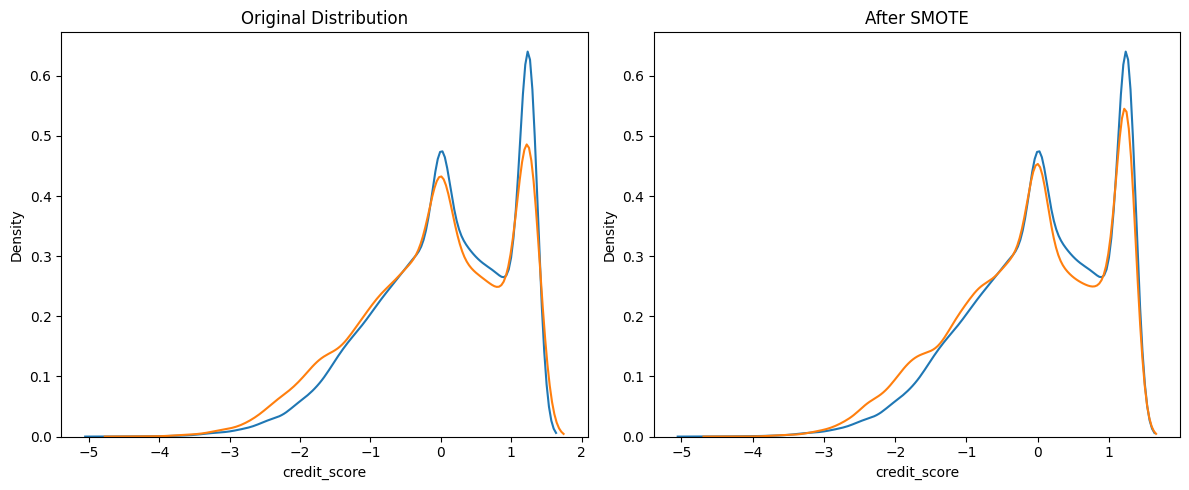

In [ ]:
# Plot distributions for loan amount and credit score
plot_feature_distributions(X_train_scaled, X_train_smote,
                         y_train, y_train_smote,
                         numerical_features.index('loan_amount'))
plot_feature_distributions(X_train_scaled, X_train_smote,
                         y_train, y_train_smote,
                         numerical_features.index('credit_score'))


## Undersampling Strategies
--------------------------
Reduce the majority class to balance the dataset.

In [ ]:

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after undersampling:")
print(pd.Series(y_train_under).value_counts(normalize=True))


Class distribution after undersampling:
default
0    0.5
1    0.5
Name: proportion, dtype: float64



# Lecture 13: Handling High Cardinality Features
==============================================



Key Learning Objectives:
1. Understand the challenges of high cardinality features
2. Learn different encoding strategies
3. Implement frequency-based encoding
4. Apply target-based encoding



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from scipy.stats import chi2_contingency

In [ ]:
# Load the dataset
df = pd.read_csv('loan_applications.csv')

In [ ]:
# Identify categorical columns and their cardinality
categorical_columns = ['city', 'occupation', 'education', 'gender']
cardinality_stats = pd.DataFrame({
    'Feature': categorical_columns,
    'Unique_Values': [df[col].nunique() for col in categorical_columns],
    'Unique_Ratio': [df[col].nunique() / len(df) for col in categorical_columns]
}).sort_values('Unique_Values', ascending=False)

print("Cardinality Analysis:")
print(cardinality_stats)

Cardinality Analysis:
      Feature  Unique_Values  Unique_Ratio
0        city            100       0.00200
1  occupation              6       0.00012
2   education              5       0.00010
3      gender              2       0.00004


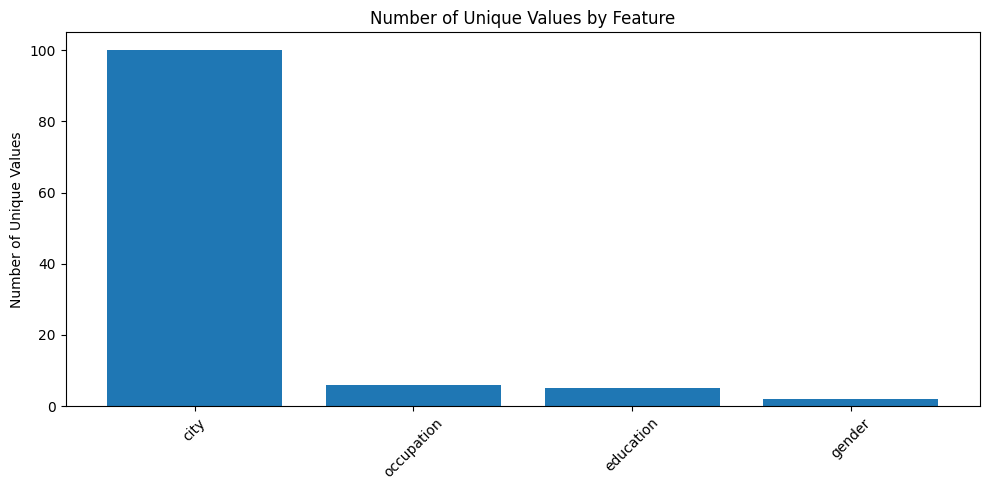

In [ ]:
# Visualize cardinality
plt.figure(figsize=(10, 5))
plt.bar(cardinality_stats['Feature'], cardinality_stats['Unique_Values'])
plt.title('Number of Unique Values by Feature')
plt.xticks(rotation=45)
plt.ylabel('Number of Unique Values')
plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate and plot frequency encoding
def apply_frequency_encoding(df, feature):
    freq_encoding = df[feature].value_counts(normalize=True)

    # Create frequency encoded feature
    encoded_feature = df[feature].map(freq_encoding)

    # Plot original vs encoded distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    freq_encoding.head(10).plot(kind='bar')
    plt.title(f'Top 10 {feature} Categories')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='default', y=encoded_feature, data=df)
    plt.title(f'Frequency Encoded {feature} vs Default')

    plt.tight_layout()
    plt.show()

    return encoded_feature

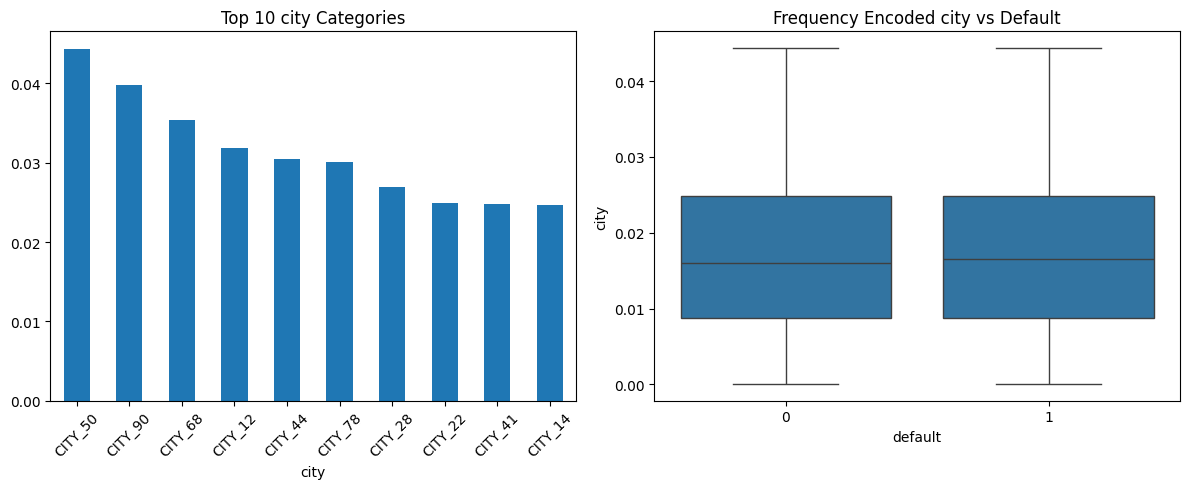

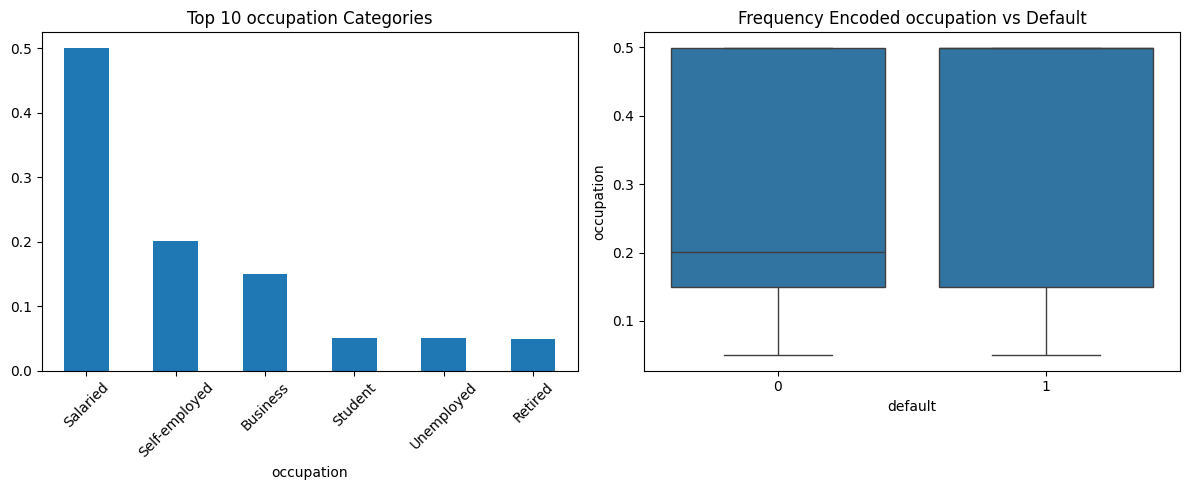

In [ ]:
# Apply frequency encoding to city and occupation
df['city_freq'] = apply_frequency_encoding(df, 'city')
df['occupation_freq'] = apply_frequency_encoding(df, 'occupation')

## Handling Rare Categories
--------------------------
Group rare categories to reduce cardinality while preserving information.

In [ ]:
def group_rare_categories(df, feature, min_freq=0.01):
    # Calculate frequency of each category
    freq = df[feature].value_counts(normalize=True)

    # Create mapping for rare categories
    mapping = {cat: cat if freq[cat] >= min_freq else 'Other'
              for cat in freq.index}

    # Apply mapping
    grouped = df[feature].map(mapping)

    # Visualize before and after
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    df[feature].value_counts().head(10).plot(kind='bar')
    plt.title(f'Original {feature} Distribution')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    grouped.value_counts().plot(kind='bar')
    plt.title(f'Grouped {feature} Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return grouped

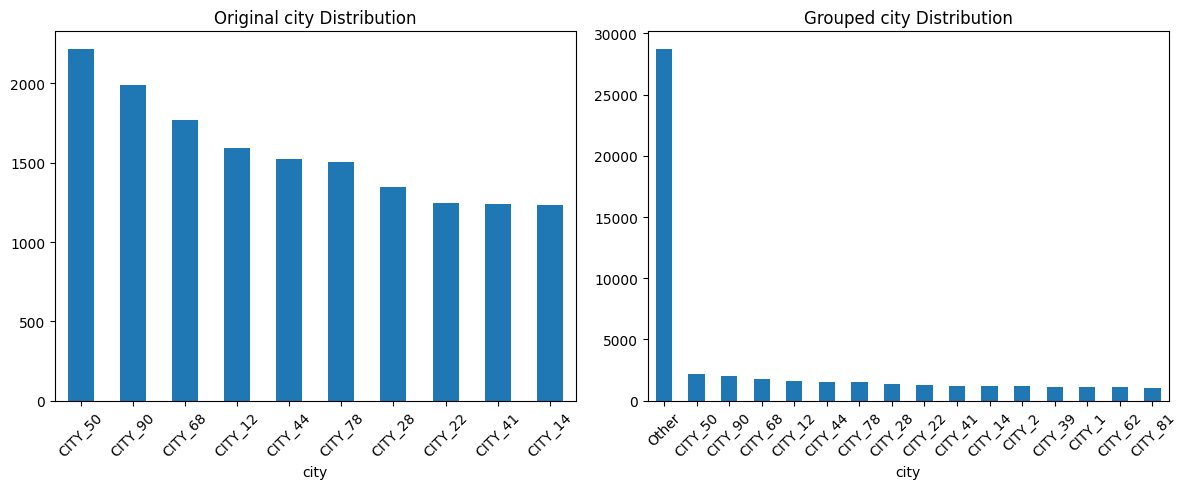

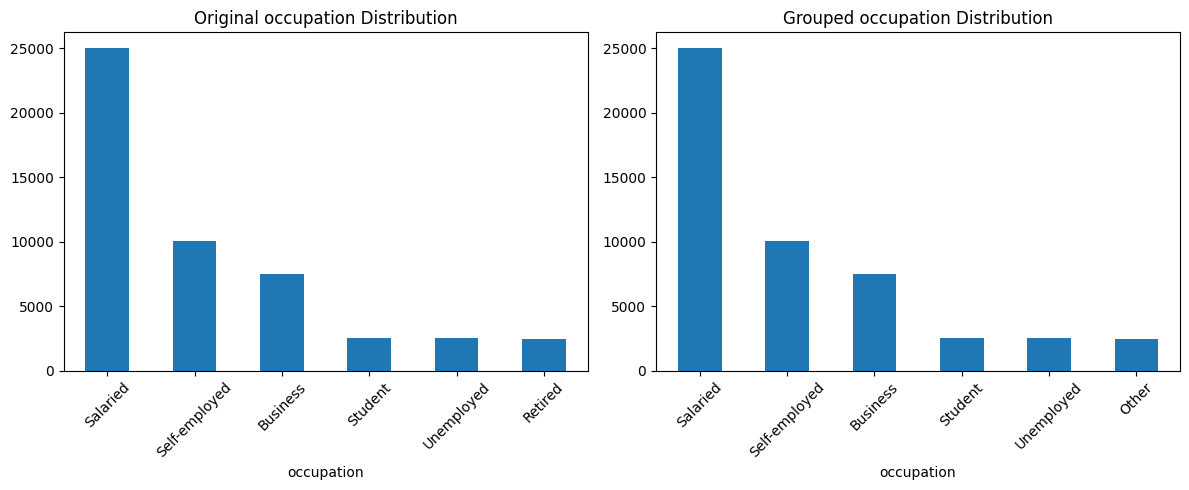

In [ ]:
# Group rare categories
df['city_grouped'] = group_rare_categories(df, 'city', min_freq=0.02)
df['occupation_grouped'] = group_rare_categories(df, 'occupation', min_freq=0.05)

# Lecture 14: Feature Selection Techniques
=====================================

Key Learning Objectives:
1. Understand different feature selection approaches
2. Apply correlation-based selection
3. Implement model-based selection
4. Compare feature importance across methods

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset with encoded features
df = pd.read_csv('loan_applications.csv')

In [ ]:
# Select numerical features
numerical_features = [
    'age', 'employment_length', 'income', 'loan_amount',
    'loan_term', 'interest_rate', 'monthly_payment',
    'credit_score', 'existing_loans'
]

In [ ]:
correlations = df[numerical_features + ['default']].corr()['default'].sort_values(ascending=False)


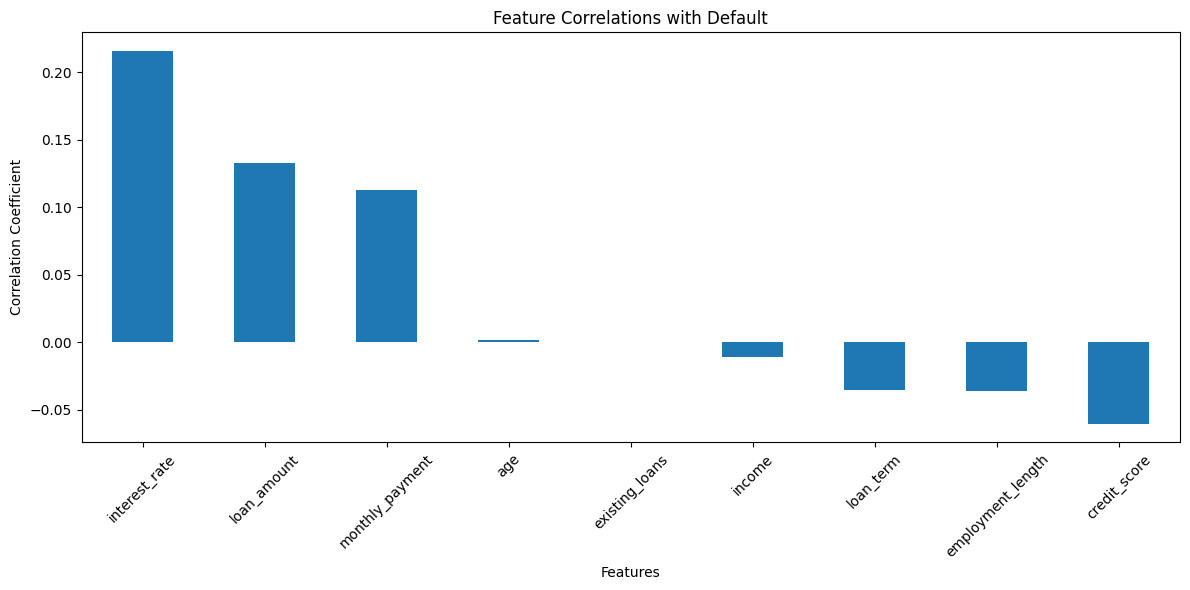

In [ ]:
# Visualize correlations
plt.figure(figsize=(12, 6))
correlations.drop('default').plot(kind='bar')
plt.title('Feature Correlations with Default')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Mutual Information Analysis
-----------------------------
Use mutual information to capture non-linear relationships.

In [ ]:
# Prepare features for mutual information
X = df[numerical_features]
y = df['default']

# Handle missing values
X = X.fillna(X.mean())


In [ ]:

# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

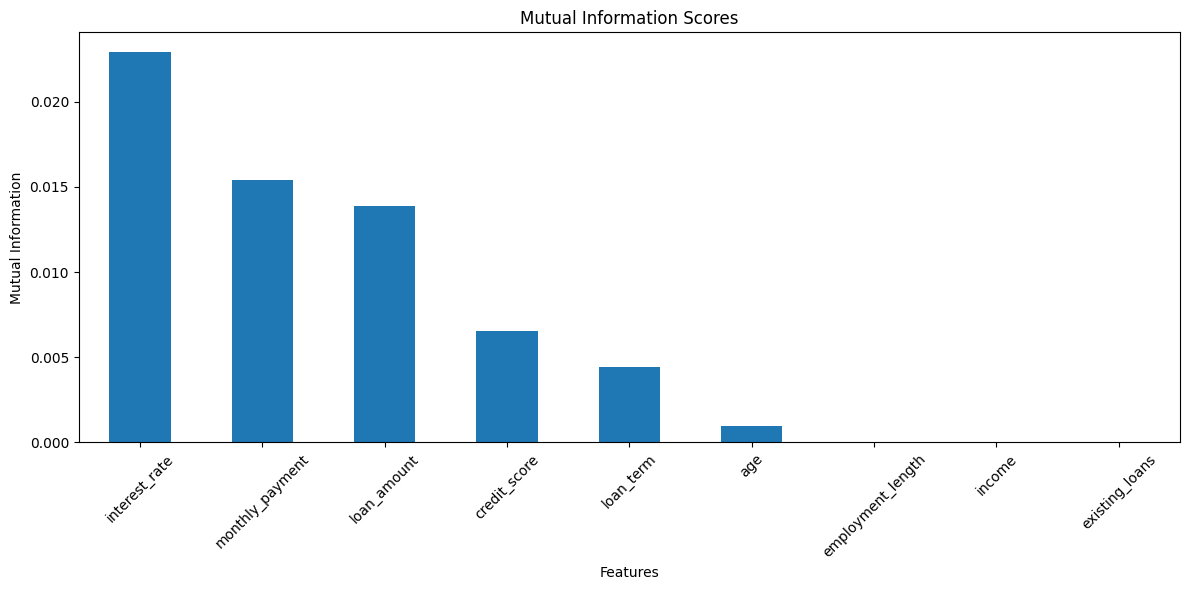

In [ ]:

# Visualize mutual information scores
plt.figure(figsize=(12, 6))
mi_series.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model-based Feature Importance
--------------------------------
Use Random Forest to evaluate feature importance.

In [ ]:
# Prepare all features (numerical + encoded)
all_features = numerical_features

In [ ]:
X_all = df[all_features].fillna(df[all_features].mean())
y = df['default']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

RandomForestClassifier(random_state=42)

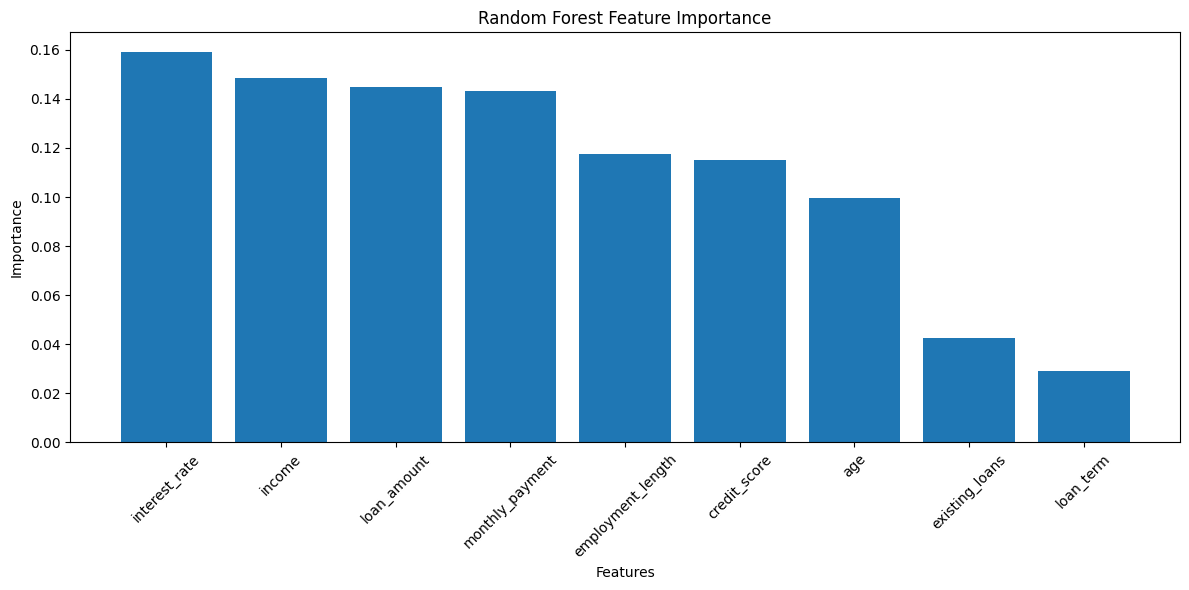

In [ ]:

# Get feature importance
importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance['Feature'], importance['Importance'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
